In [2]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import scipy.stats as stats

sys.path.append("..")
from util.post import AnalyzedSeeg

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
dfr = pd.read_pickle("../run/Taa/df-grouped-rec.pkl")

In [4]:
from matplotlib.patches import Rectangle
import itertools

def scale_bars(ax, pos, sizex=None, labelx=None, sizey=None, labely=None, barwidth=4, fontsize=14):
    if sizex:
        sizex_ax = ax.transLimits.transform((sizex, 0))[0] - ax.transLimits.transform((0, 0))[0]
        ax.add_artist(Rectangle(pos, sizex_ax, 0, lw=barwidth, ec='black', transform=ax.transAxes))
        if labelx:
            ax.annotate(labelx, xy=(pos[0] + 0.5*sizex_ax, pos[1]), xycoords='axes fraction',
                        xytext=(0, -0.5*fontsize), textcoords='offset points', ha='center', va='top',
                        fontsize=fontsize)
            
    if sizey:
        sizey_ax = ax.transLimits.transform((0, sizey))[1] - ax.transLimits.transform((0, 0))[1]
        ax.add_artist(Rectangle(pos, 0, sizey_ax, lw=barwidth, ec='black', transform=ax.transAxes))
        if labely:
            ax.annotate(labely, xy=(pos[0], pos[1] + 0.5*sizey_ax), xycoords='axes fraction',
                        xytext=(-0.5*fontsize, 0), textcoords='offset points', ha='right', va='center',
                        fontsize=fontsize)
            

def add_panel_letters(fig, axes=None, fontsize=30, xpos=-0.04, ypos=1.05):
    labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    if axes is None:
        axes = fig.get_axes()

    if type(xpos) == float:
        xpos = itertools.repeat(xpos)
    if type(ypos) == float:
        ypos = itertools.repeat(ypos)

    for i, (ax, x, y) in enumerate(zip(axes, xpos, ypos)):
        ax.text(x, y, labels[i],
                transform=ax.transAxes, size=fontsize, weight='bold')            

In [5]:
def add_line_coords(df):
    df['line_coord'] = [[] for _ in range(len(df))]
    df['slope'] = 0.
    df['intercept'] = 0.
    
    for i, row in df.iterrows():
        contact_file = f"../data/Geometry/{row.subject}/seeg.txt"    
        cnames = list(np.genfromtxt(contact_file, usecols=(0,), dtype=str))
        cpos = np.genfromtxt(contact_file, usecols=(1,2,3), dtype=float)
        cpos_taa = np.array([cpos[cnames.index(name)] for name in row.contacts])
        line_coord = list(np.linalg.norm(cpos_taa - cpos_taa[0], axis=1))
        
        slope, intercept, rval, _, _ = stats.linregress(line_coord, row.tfr)
        
        df.at[i, 'line_coord'] = line_coord
        df.loc[i, 'slope'] = slope
        df.loc[i, 'intercept'] = intercept       
        
add_line_coords(dfr)

In [6]:
taa = dfr.loc[27]
ind = 2

rec = np.load(f"../data/Recordings/{taa.subject}/rec_{taa.rec:04d}.npz")
inds = [list(rec['names']).index(c) for c in taa.contacts]

tfr = np.array(taa.tfr)
tto = np.array(taa.tto)
tdur = tto - tfr

t = rec['t']
seeg = rec['seeg'][inds,  :]

ans = AnalyzedSeeg(t, seeg, taa.contacts, rec['onset'], rec['termination'])

In [7]:
mask = (t > np.min(tfr) - 8) * (t < np.max(tto) + 6)
t = t[mask]
seeg = rec['seeg'][inds][:, mask]
# seeg /= 0.5 * np.max(np.abs(seeg))
seeg *= 2 / np.max(np.abs(seeg))

taamask = (t > np.min(taa.tfr)) * (t < max(np.max(taa.tto), np.min(taa.tfr) + 5.0))
taaseeg = seeg[:, taamask]
taaseeg -= np.mean(taaseeg, axis=1)[:, None]

pca = PCA(n_components=5)
comps = pca.fit_transform(taaseeg.T)
var_explained = pca.explained_variance_ratio_
pca_ve_acc = np.cumsum(var_explained)

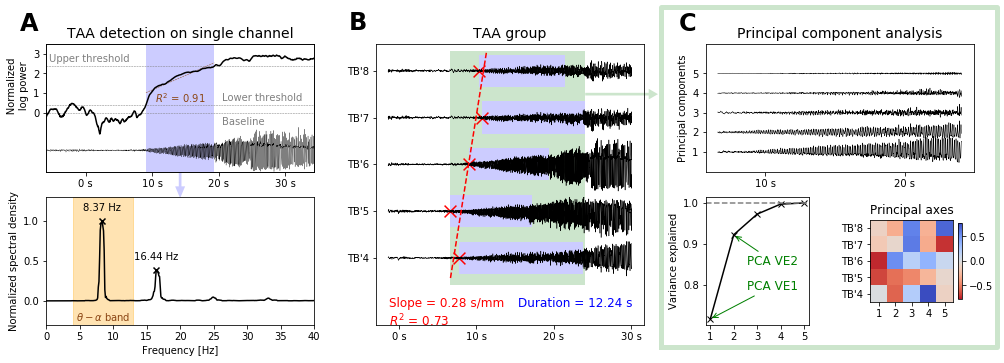

In [8]:
fig = plt.figure(figsize=(14, 5))

# Panel A: Solo trace, log power --------------------------------------------------------------------------
ax0 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
plt.title("TAA detection on single channel", fontsize=14)

plt.plot(ans.t_lnta, ans.lnta[ind], color='k', zorder=10)
# plt.text(263,  0.6, "Log power", color='k', va='bottom', ha='left')

plt.axhline(0.0, color='0.5', ls='--', lw=0.5)
plt.axhline(ans.lnta_lower_threshold[ind], color='0.5', ls='--', lw=0.5)
plt.axhline(ans.lnta_upper_threshold[ind], color='0.5', ls='--', lw=0.5)
plt.text(263, ans.lnta_upper_threshold[ind] + 0.1, "Upper threshold", va='bottom', ha='left', color='0.5')
plt.text(289, ans.lnta_lower_threshold[ind] + 0.1, "Lower threshold", va='bottom', ha='left', color='0.5')
plt.text(289, -0.2, "Baseline", va='top', ha='left', color='0.5')

plt.axvspan(taa.tfr[ind], taa.tto[ind], zorder=-3, color='#CCCCFF', alpha=1.0, lw=0.)
plt.arrow((taa.tfr[ind] + taa.tto[ind])/2, -3, 0, -0.75, color='#CCCCFF', alpha=1.0, clip_on=False, 
          width=0.4, head_width=1.5, head_length=0.6, lw=0.)

tt = np.linspace(tfr[ind], tto[ind], 2)
plt.plot(tt, ans.intercept[ind] + ans.slope[ind]*tt, color='saddlebrown', ls='--', lw=0.5)
plt.text(279, 0.5, f"$R^2$ = {ans.r2[ind]:.2f}", color='saddlebrown')

plt.yticks([0, 1, 2, 3])
plt.ylim(-3, 3.5)
plt.ylabel("              Normalized\n              log power")

tticks = np.array([0, 10, 20, 30])
plt.xticks(tticks + rec['onset'], [f"{tt} s" for tt in tticks])

ax0b = ax0.twinx()
plt.plot(ans.time, ans.seeg[ind, :], lw=0.25, color='k')
plt.ylim(-2000, 10000)
plt.yticks([])
plt.xlim(taa.tfr[ind] - 15, taa.tto[ind] + 15)


# Panel A2: Frequencies ---------------------------------------------------------------------------------
ax1 = plt.subplot2grid((2, 6), (1, 0), colspan=2)
plt.plot(ans.sa_freqs[ind], ans.sa_spect[ind], color='k')
plt.scatter(ans.sa_fpeaks[ind], ans.sa_peaks[ind], marker='x', color='k', zorder=5)
for f, yf in zip(ans.sa_fpeaks[ind], ans.sa_peaks[ind]):
    plt.text(f, yf + 0.1, f"{f:.2f} Hz", ha='center', va='bottom')

plt.axvspan(4.0, 13.0, color='orange', alpha=0.3)
plt.xlim([0, 40])
plt.xlabel("Frequency [Hz]")
plt.ylim(-0.3, 1.3)
plt.ylabel("Normalized spectral density")
plt.text(8.5, -0.2, r"$\theta-\alpha$ band", ha='center', va='center', color='saddlebrown')


# Panel B: Traces, linregress, duration
ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan=2, colspan=2)
plt.title("TAA group", fontsize=14)
for i in range(len(inds)):
    # lc = taa.line_coord[i]
    lc = 3.5*i    
    plt.plot(t, seeg[i] + lc, color='k', lw=0.5)
    plt.scatter([tfr[i]], [lc], color='r', marker='x', s=140)    
    plt.fill_between([tfr[i], tto[i]], [lc-1.2, lc-1.2], [lc+1.2, lc+1.2], color='#CCCCFF', alpha=1.0,
                     zorder=-1, lw=0.)
    
x = np.linspace(-1.5, max(taa.line_coord) + 1.8, 100)
plt.plot(taa.intercept + taa.slope * x, x, color='r', ls='--')
plt.text(0.05, 0.1, f"Slope = {taa.tfr_slope:.2f} s/mm\n$R^2$ = {taa.tfr_r2:.2f}",
         fontsize=12, color='r', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.53, 0.1, f"Duration = {np.mean(tdur):.2f} s", 
         fontsize=12, color='b', ha='left', va='top', transform=plt.gca().transAxes)
# plt.yticks(taa.line_coord, taa.contacts)
plt.yticks(3.5*np.r_[:len(taa.contacts)], taa.contacts)
# plt.xticks([])
plt.xticks(tticks + rec['onset'], [f"{tt} s" for tt in tticks])

plt.ylim(-5, 16.)
# scale_bars(ax2, (0.1, 0.97), sizex=1, labelx="1 s")

tt0 = np.min(taa.tfr)
tt1 = max(np.max(taa.tto), np.min(taa.tfr) + 5.0)
# lc = np.max(taa.line_coord[-1])
lc = 3.5 * (taa.ncontacts - 1)
plt.fill_between([tt0, tt1], [-2, -2], [lc+1.5, lc+1.5], color='g', alpha=0.2, zorder=-3, lw=0.)
plt.arrow(tt1, 12.25, 8.2, 0, color='g', alpha=0.2, clip_on=False, width=0.2, head_width=0.8, lw=0.)



# Panel C: PCA components
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
plt.title("Principal component analysis", fontsize=14)
for i in range(5):
    plt.plot(t[taamask], 0.4*comps[:, i] + i, color='k', lw=0.5)
# plt.xticks([])
tticks = np.array([10, 20])
plt.xticks(tticks + rec['onset'], [f"{tt} s" for tt in tticks])
# scale_bars(ax3, (0.1, 0.9), sizex=1, labelx="1 s")
plt.ylim(-1, 5.5)
plt.yticks(np.r_[:5], np.r_[:5] + 1)
plt.ylabel("Principal components")


# Panel C2: Variance explained
ax4 = plt.subplot2grid((2, 6), (1, 4))
plt.plot(pca_ve_acc, 'kx-')
plt.axhline(1.0, ls='--', color='0.5')
plt.xticks(np.r_[:5], np.r_[:5] + 1)
plt.ylabel("Variance explained")
for i in [0, 1]:
    plt.annotate(f"PCA VE{i+1}", xy=(i, pca_ve_acc[i]),
                # f"PCA VE{i+1} = {pca_ve_acc[i]:.3f}", xy=(i, pca_ve_acc[i]),
                 textcoords='axes fraction',
                 xytext=(0.4, 0.3 + 0.2*i),
                 fontsize=12, color='g',
                 arrowprops=dict(fc='g', ec='g', arrowstyle="->"), va='center')

# Panel C3: Principal axes
ax5 = plt.subplot2grid((2, 6), (1, 5))
plt.title("Principal axes")
vmax = np.max(np.abs(pca.components_))
plt.imshow(pca.components_.T, cmap='coolwarm_r', vmin=-vmax, vmax=vmax)
plt.colorbar(orientation='vertical', ticks=[-0.5, 0, 0.5], shrink=0.6)
plt.xticks(np.r_[:5], np.r_[:5] + 1)
plt.yticks(np.r_[:taa.ncontacts], taa.contacts)
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, taa.ncontacts-0.5)
plt.plot([-13.2, 7.2, 7.2, -13.2, -13.2], [-3.2, -3.2, 17.4, 17.4, -3.2], color='g', alpha=0.2, lw=5, clip_on=False)
    
        
add_panel_letters(fig, [ax0, ax2, ax3], fontsize=24, xpos=-0.1, ypos=[1.1, 1.05, 1.1])
plt.subplots_adjust(wspace=0.6, hspace=0.2, left=0.05, right=0.97, top=0.88, bottom=0.1)
plt.savefig("figs/taa-features.pdf")